In [1]:
import cptac
import cptac.utils as ut
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.plotting import add_at_risk_counts

import pickle

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

import copy
import math

cptac.list_datasets()

,Description,Data reuse status,Publication link
Dataset name,,,
Brca,breast cancer,no restrictions,https://pubmed.ncbi.nlm.nih.gov/33212010/
Ccrcc,clear cell renal cell carcinoma (kidney),no restrictions,https://pubmed.ncbi.nlm.nih.gov/31675502/
Colon,colorectal cancer,no restrictions,https://pubmed.ncbi.nlm.nih.gov/31031003/
Endometrial,endometrial carcinoma (uterine),no restrictions,https://pubmed.ncbi.nlm.nih.gov/32059776/
Gbm,glioblastoma,no restrictions,https://pubmed.ncbi.nlm.nih.gov/33577785/
Hnscc,head and neck squamous cell carcinoma,no restrictions,https://pubmed.ncbi.nlm.nih.gov/33417831/
Lscc,lung squamous cell carcinoma,no restrictions,https://pubmed.ncbi.nlm.nih.gov/34358469/
Luad,lung adenocarcinoma,no restrictions,https://pubmed.ncbi.nlm.nih.gov/32649874/
Ovarian,high grade serous ovarian cancer,no restrictions,https://pubmed.ncbi.nlm.nih.gov/27372738/


In [2]:
#If pull fresh

datasets = {#"Brca": cptac.Brca(),
            "Ccrcc": cptac.Ccrcc(), 
            #"Colon": cptac.Colon(), 
            "Endometrial": cptac.Endometrial(),
            #"Gbm": cptac.Gbm(),
            "Hnscc": cptac.Hnscc(), 
            #"Lscc": cptac.Lscc(),
            "Luad": cptac.Luad(), 
            "Ovarian": cptac.Ovarian(), 
           }

for i in list(datasets.keys()):
    datum = datasets[i]
    datasets[i] = [
        datum,
        datum.get_clinical(),
        datum.get_proteomics(),
    ]

with open("CPTAC_Data", "wb") as f:
    pickle.dump(datasets, f)

In [64]:
#Load from pickle
with open("CPTAC_Data", "rb") as f:
    datasets = pickle.load(f)

<ipython-input-65-162e61075572>:34: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  patients = patients.assign(Days=patients[cols].sum(1)).drop(cols,1)


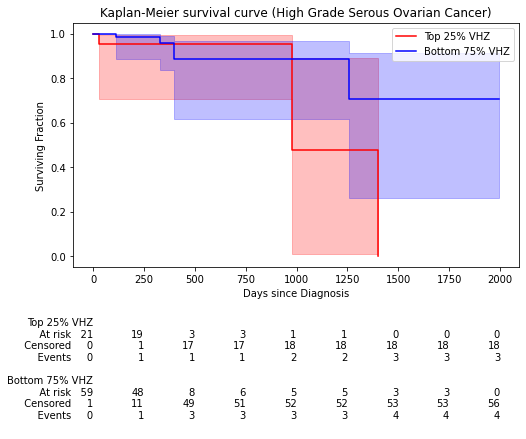

In [65]:
#0: Ovarian

#Define datasets
ov = datasets["Ovarian"][0]
clinical = datasets["Ovarian"][1]
proteomics = datasets["Ovarian"][2]

#Join clinical and proteomics data
clinical_proteomics_clean = ov.join_metadata_to_omics(
    metadata_df_name="clinical", 
    metadata_cols = ['Days_Between_Collection_And_Last_Contact', 'Vital_Status','Days_Between_Collection_And_Death'], 
    omics_df_name="proteomics", 
    omics_genes="DUSP23",
    quiet=True
)

#Remove multi-index
clinical_proteomics_clean = clinical_proteomics_clean.droplevel(1, axis=1)
clinical_proteomics_clean.index.name = None

#Sanity check: Drop rows with NaN DUSP23 expression and duplicates
clinical_proteomics_clean = clinical_proteomics_clean.dropna(
    how='any', subset=['DUSP23_proteomics', 'Vital_Status']
)
patients = clinical_proteomics_clean.drop_duplicates()

# Change vital status to boolean
patients["Vital_Status"] = patients["Vital_Status"].replace("Living", False)
patients["Vital_Status"] = patients["Vital_Status"].replace("Deceased", True)
patients['Vital_Status'] = patients['Vital_Status'].astype('bool')

#Change days to single column
cols = ['Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']
patients = patients.assign(Days=patients[cols].sum(1)).drop(cols,1)

#Plot KM
ax = plt.subplot(111)

kmf_top = KaplanMeierFitter()
kmf_bottom = KaplanMeierFitter()

cutoff = patients["DUSP23_proteomics"].quantile(0.75)
patients_top = patients[patients["DUSP23_proteomics"] >= cutoff]
patients_bottom = patients[patients["DUSP23_proteomics"] < cutoff]

ax = kmf_top.fit(patients_top["Days"], event_observed=patients_top["Vital_Status"], label="Top 25% VHZ").plot_survival_function(ax=ax, color="red")
ax = kmf_bottom.fit(patients_bottom["Days"], event_observed=patients_bottom["Vital_Status"], label="Bottom 75% VHZ").plot_survival_function(ax=ax, color="blue")

add_at_risk_counts(kmf_top, kmf_bottom, ax=ax)

#Beautification
plt.title("Kaplan-Meier survival curve (High Grade Serous Ovarian Cancer)")
ax.set_xlabel("Days since Diagnosis")
ax.set_ylabel("Surviving Fraction")
plt.savefig("Ovarian.svg", dpi=500, bbox_inches='tight')
plt.show()

#Further Cox regression
Ovarian_patients = copy.deepcopy(patients)


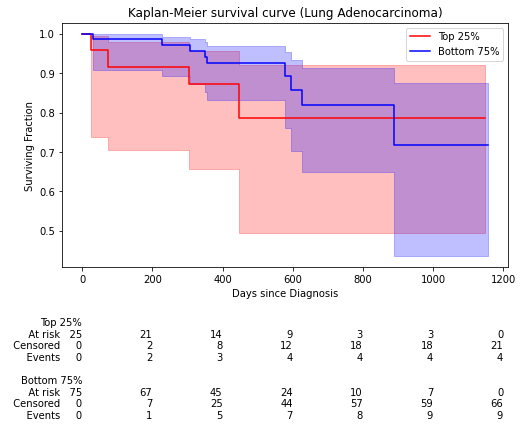

In [66]:
#1: Luad

luad = datasets["Luad"][0]
clinical = datasets["Luad"][1]
proteomics = datasets["Luad"][2]
followup = luad.get_followup()

patients = {}

#Populate patients from followup
for index, row in followup.iterrows():
    if index not in list(patients.keys()):
        patients[index] = [max(row[5], row[7]),
                          True if row[4]=="Deceased" else False]
    else:
        new_day = max(row[5], row[7])
        if new_day>patients[index][0]:
            patients[index] = [new_day, 
                               True if row[4]=="Deceased" else False]

patients_final = {}

for index in list(patients.keys()):
    try:
        val = proteomics["DUSP23"].loc[index][0]
        patients[index].append(val)
        patients_final[index] = copy.deepcopy(patients[index])
    except:
        continue

patients_final = pd.DataFrame([patients_final[i] for i in list(patients_final.keys())], 
                              list(patients_final.keys()), 
                              ["Days", "Vital_Status", "DUSP23_proteomics"])

#Plot KM
ax = plt.subplot(111)

kmf_top = KaplanMeierFitter()
kmf_bottom = KaplanMeierFitter()

cutoff = patients_final["DUSP23_proteomics"].quantile(0.75)
patients_top = patients_final[patients_final["DUSP23_proteomics"] >= cutoff]
patients_bottom = patients_final[patients_final["DUSP23_proteomics"] < cutoff]

ax = kmf_top.fit(patients_top["Days"], event_observed=patients_top["Vital_Status"], label="Top 25%").plot_survival_function(ax=ax, color="red")
ax = kmf_bottom.fit(patients_bottom["Days"], event_observed=patients_bottom["Vital_Status"], label="Bottom 75%").plot_survival_function(ax=ax, color="blue")

add_at_risk_counts(kmf_top, kmf_bottom, ax=ax)

#Beautification
plt.title("Kaplan-Meier survival curve (Lung Adenocarcinoma)")
ax.set_xlabel("Days since Diagnosis")
ax.set_ylabel("Surviving Fraction")
plt.savefig("Luad.svg", dpi=500, bbox_inches='tight')
plt.show()

#Further Cox regression
Luad_patients = copy.deepcopy(patients_final)


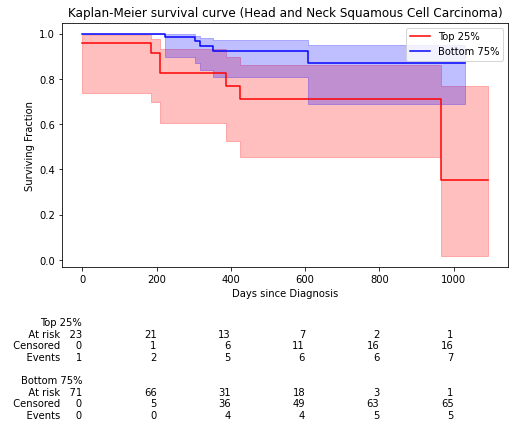

In [67]:
#2: Hnscc

hnscc = datasets["Hnscc"][0]
clinical = datasets["Hnscc"][1]
proteomics = datasets["Hnscc"][2]
followup = hnscc.get_followup()

patients = {}

#Populate patients from followup
for index, row in followup.iterrows():
    if index not in list(patients.keys()):
        patients[index] = [max(row[4], row[6]),
                          True if row[3]=="Deceased" else False]
    else:
        new_day = max(row[4], row[6])
        if new_day>patients[index][0]:
            patients[index] = [new_day, 
                               True if row[3]=="Deceased" else False]

#There's a weird -9.0 value. Rebase to 0 lol
for i in patients.values():
    i[0]+=9.0

patients_final = {}

#Populate proteomics data
for index in list(patients.keys()):
    try:
        val = proteomics["DUSP23"].loc[index]
        patients[index].append(val)
        patients_final[index] = copy.deepcopy(patients[index])
    except:
        continue

patients_final = pd.DataFrame([patients_final[i] for i in list(patients_final.keys())], 
                              list(patients_final.keys()), 
                              ["Days", "Vital_Status", "DUSP23_proteomics"])

#Plot KM
ax = plt.subplot(111)

kmf_top = KaplanMeierFitter()
kmf_bottom = KaplanMeierFitter()

cutoff = patients_final["DUSP23_proteomics"].quantile(0.75)
patients_top = patients_final[patients_final["DUSP23_proteomics"] >= cutoff]
patients_bottom = patients_final[patients_final["DUSP23_proteomics"] < cutoff]

ax = kmf_top.fit(patients_top["Days"], event_observed=patients_top["Vital_Status"], label="Top 25%").plot_survival_function(ax=ax, color="red")
ax = kmf_bottom.fit(patients_bottom["Days"], event_observed=patients_bottom["Vital_Status"], label="Bottom 75%").plot_survival_function(ax=ax, color="blue")

add_at_risk_counts(kmf_top, kmf_bottom, ax=ax)

#Beautification
plt.title("Kaplan-Meier survival curve (Head and Neck Squamous Cell Carcinoma)")
ax.set_xlabel("Days since Diagnosis")
ax.set_ylabel("Surviving Fraction")
plt.savefig("Hnscc.svg", dpi=500, bbox_inches='tight')
plt.show()

#Further Cox regression
Hnscc_patients = copy.deepcopy(patients_final)



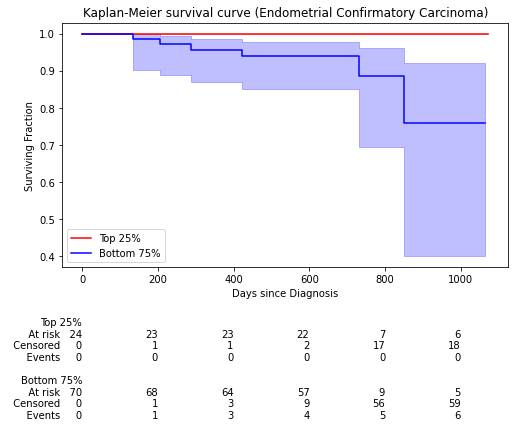

In [68]:
#3: Endometrial

endometrial = datasets["Endometrial"][0]
clinical = datasets["Endometrial"][1]
proteomics = datasets["Endometrial"][2]
followup = endometrial.get_followup()

patients = {}

#Populate patients from followup
for index, row in followup.iterrows():
    if index not in list(patients.keys()):
        patients[index] = [max(row[5], row[7]),
                          True if row[4]=="Deceased" else False]
    else:
        new_day = max(row[5], row[7])
        if new_day>patients[index][0]:
            patients[index] = [new_day, 
                               True if row[4]=="Deceased" else False]


patients_final = {}

#Populate proteomics data
for index in list(patients.keys()):
    try:
        val = proteomics["DUSP23"].loc[index]
        patients[index].append(val)
        patients_final[index] = copy.deepcopy(patients[index])
    except:
        continue

patients_final = pd.DataFrame([patients_final[i] for i in list(patients_final.keys())], 
                              list(patients_final.keys()), 
                              ["Days", "Vital_Status", "DUSP23_proteomics"])

patients_final = patients_final.dropna(axis=0, how="any")

#Plot KM
ax = plt.subplot(111)

kmf_top = KaplanMeierFitter()
kmf_bottom = KaplanMeierFitter()

cutoff = patients_final["DUSP23_proteomics"].quantile(0.75)
patients_top = patients_final[patients_final["DUSP23_proteomics"] >= cutoff]
patients_bottom = patients_final[patients_final["DUSP23_proteomics"] < cutoff]

ax = kmf_top.fit(patients_top["Days"], event_observed=patients_top["Vital_Status"], label="Top 25%").plot_survival_function(ax=ax, color="red")
ax = kmf_bottom.fit(patients_bottom["Days"], event_observed=patients_bottom["Vital_Status"], label="Bottom 75%").plot_survival_function(ax=ax, color="blue")

add_at_risk_counts(kmf_top, kmf_bottom, ax=ax)

#Beautification
plt.title("Kaplan-Meier survival curve (Endometrial Confirmatory Carcinoma)")
ax.set_xlabel("Days since Diagnosis")
ax.set_ylabel("Surviving Fraction")
plt.savefig("Endometrial.svg", dpi=500, bbox_inches='tight')
plt.show()

#Further Cox regression
Endometrial_patients = copy.deepcopy(patients_final)



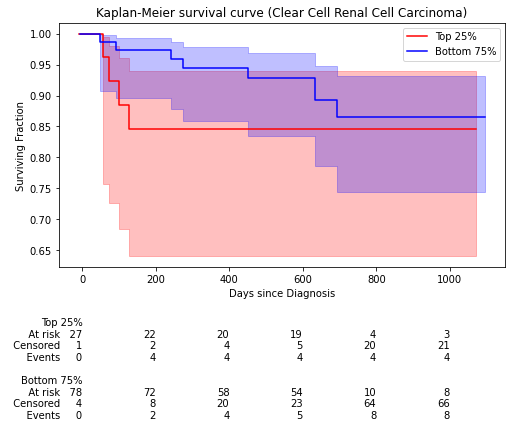

In [69]:
#4: Ccrcc

ccrcc = datasets["Ccrcc"][0]
clinical = datasets["Ccrcc"][1]
proteomics = datasets["Ccrcc"][2]
followup = ccrcc.get_followup()

patients = {}

#Populate patients from followup
for index, row in followup.iterrows():
    if index not in list(patients.keys()):
        patients[index] = [max(row[5], row[7]),
                          True if row[4]=="Deceased" else False]
    else:
        new_day = max(row[5], row[7])
        if new_day>patients[index][0]:
            patients[index] = [new_day, 
                               True if row[4]=="Deceased" else False]

patients_final = {}

#Populate proteomics data
for index in list(patients.keys()):
    try:
        val = proteomics["DUSP23"].loc[index][0]
        patients[index].append(val)
        patients_final[index] = copy.deepcopy(patients[index])
    except:
        continue

patients_final = pd.DataFrame([patients_final[i] for i in list(patients_final.keys())], 
                              list(patients_final.keys()), 
                              ["Days", "Vital_Status", "DUSP23_proteomics"])

patients_final = patients_final.dropna(axis=0, how="any")

#Plot KM
ax = plt.subplot(111)

kmf_top = KaplanMeierFitter()
kmf_bottom = KaplanMeierFitter()

cutoff = patients_final["DUSP23_proteomics"].quantile(0.75)
patients_top = patients_final[patients_final["DUSP23_proteomics"] >= cutoff]
patients_bottom = patients_final[patients_final["DUSP23_proteomics"] < cutoff]

ax = kmf_top.fit(patients_top["Days"], event_observed=patients_top["Vital_Status"], label="Top 25%").plot_survival_function(ax=ax, color="red")
ax = kmf_bottom.fit(patients_bottom["Days"], event_observed=patients_bottom["Vital_Status"], label="Bottom 75%").plot_survival_function(ax=ax, color="blue")

add_at_risk_counts(kmf_top, kmf_bottom, ax=ax)

#Beautification
plt.title("Kaplan-Meier survival curve (Clear Cell Renal Cell Carcinoma)")
ax.set_xlabel("Days since Diagnosis")
ax.set_ylabel("Surviving Fraction")
plt.savefig("Ccrcc.svg", dpi=500, bbox_inches='tight')
plt.show()


#Further Cox regression
Ccrcc_patients = copy.deepcopy(patients_final)

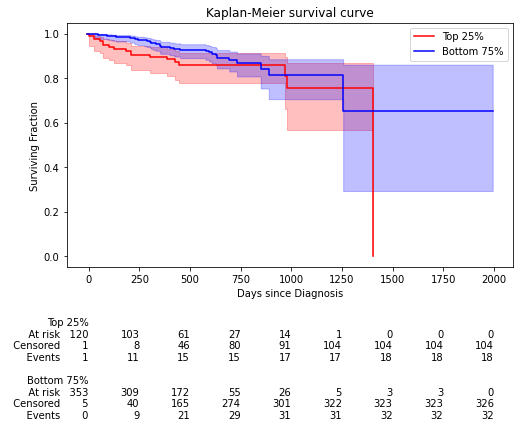

In [70]:
#Pooled analysis

all_patients = [Ovarian_patients, Luad_patients, Hnscc_patients, Endometrial_patients, Ccrcc_patients]

cutoff_val = 0.75

patients_top = [i[i["DUSP23_proteomics"] >= i["DUSP23_proteomics"].quantile(cutoff_val)] for i in all_patients]
patients_bottom = [i[i["DUSP23_proteomics"] < i["DUSP23_proteomics"].quantile(cutoff_val)] for i in all_patients]

patients_top_final = pd.concat(patients_top)
patients_bottom_final = pd.concat(patients_bottom)
patients_final = pd.concat([patients_top_final, patients_bottom_final])

#Plot KM
ax = plt.subplot(111)

kmf_top = KaplanMeierFitter()
kmf_bottom = KaplanMeierFitter()

ax = kmf_top.fit(patients_top_final["Days"], event_observed=patients_top_final["Vital_Status"], label="Top 25%").plot_survival_function(ax=ax, color="red")
ax = kmf_bottom.fit(patients_bottom_final["Days"], event_observed=patients_bottom_final["Vital_Status"], label="Bottom 75%").plot_survival_function(ax=ax, color="blue")

add_at_risk_counts(kmf_top, kmf_bottom, ax=ax)

#Beautification
plt.title("Kaplan-Meier survival curve")
ax.set_xlabel("Days since Diagnosis")
ax.set_ylabel("Surviving Fraction")
plt.savefig("Pooled.svg", dpi=500, bbox_inches='tight')

plt.show()

#Further Cox regression
Pooled_patients = copy.deepcopy(patients_final)



Ovarian


<lifelines.CoxPHFitter: fitted with 81 total observations, 74 right-censored observations>
             duration col = 'Days'
                event col = 'Vital_Status'
      baseline estimation = breslow
   number of observations = 81
number of events observed = 7
   partial log-likelihood = -20.99
         time fit was run = 2023-01-01 01:15:51 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
DUSP23_proteomics  -0.13       0.88       1.18            -2.45             2.19                 0.09                 8.94

                    cmp to     z    p   -log2(p)
covariate                                       
DUSP23_proteomics     0.00 -0.11 0.91       0.13
---
Concordance = 0.57
Partial AIC = 43.98
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.13

Proportional hazard assumption looks okay.

Luad


<lifelines.CoxPHFitter: fitted with 100 total observations, 87 right-censored observations>
             duration col = 'Days'
                event col = 'Vital_Status'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 13
   partial log-likelihood = -52.19
         time fit was run = 2023-01-01 01:15:51 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
DUSP23_proteomics   0.21       1.24       0.25            -0.28             0.70                 0.76                 2.02

                    cmp to    z    p   -log2(p)
covariate                                      
DUSP23_proteomics     0.00 0.85 0.40       1.34
---
Concordance = 0.54
Partial AIC = 106.38
log-likelihood ratio test = 0.70 on 1 df
-log2(p) of ll-ratio test = 1.31

Proportional hazard assumption looks okay.

Hnscc


<lifelines.CoxPHFitter: fitted with 95 total observations, 83 right-censored observations>
             duration col = 'Days'
                event col = 'Vital_Status'
      baseline estimation = breslow
   number of observations = 95
number of events observed = 12
   partial log-likelihood = -46.98
         time fit was run = 2023-01-01 01:15:51 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
DUSP23_proteomics   0.04       1.04       1.07            -2.06             2.13                 0.13                 8.44

                    cmp to    z    p   -log2(p)
covariate                                      
DUSP23_proteomics     0.00 0.03 0.97       0.04
---
Concordance = 0.55
Partial AIC = 95.96
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.04

Proportional hazard assumption looks okay.

Endometrial


<lifelines.CoxPHFitter: fitted with 94 total observations, 88 right-censored observations>
             duration col = 'Days'
                event col = 'Vital_Status'
      baseline estimation = breslow
   number of observations = 94
number of events observed = 6
   partial log-likelihood = -22.61
         time fit was run = 2023-01-01 01:15:51 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
DUSP23_proteomics  -1.05       0.35       0.63            -2.29             0.20                 0.10                 1.22

                    cmp to     z    p   -log2(p)
covariate                                       
DUSP23_proteomics     0.00 -1.65 0.10       3.34
---
Concordance = 0.69
Partial AIC = 47.22
log-likelihood ratio test = 2.74 on 1 df
-log2(p) of ll-ratio test = 3.36

Proportional hazard assumption looks okay.

Ccrcc


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'Days'
                event col = 'Vital_Status'
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.34
         time fit was run = 2023-01-01 01:15:51 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
DUSP23_proteomics   0.97       2.65       0.79            -0.58             2.53                 0.56                12.54

                    cmp to    z    p   -log2(p)
covariate                                      
DUSP23_proteomics     0.00 1.23 0.22       2.19
---
Concordance = 0.62
Partial AIC = 106.68
log-likelihood ratio test = 1.42 on 1 df
-log2(p) of ll-ratio test = 2.10

Proportional hazard assumption looks okay.

Pooled


<lifelines.CoxPHFitter: fitted with 480 total observations, 430 right-censored observations>
             duration col = 'Days'
                event col = 'Vital_Status'
      baseline estimation = breslow
   number of observations = 480
number of events observed = 50
   partial log-likelihood = -273.57
         time fit was run = 2023-01-01 01:15:52 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
DUSP23_proteomics   0.02       1.02       0.01            -0.00             0.05                 1.00                 1.05

                    cmp to    z    p   -log2(p)
covariate                                      
DUSP23_proteomics     0.00 1.73 0.08       3.56
---
Concordance = 0.55
Partial AIC = 549.14
log-likelihood ratio test = 2.70 on 1 df
-log2(p) of ll-ratio test = 3.32

Proportional hazard assumption looks okay.


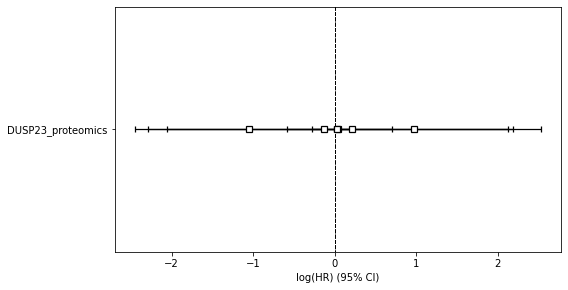

In [71]:
#Plot Cox

all_patients = [Ovarian_patients, 
                Luad_patients, 
                Hnscc_patients, 
                Endometrial_patients, 
                Ccrcc_patients,
                Pooled_patients,
               ]

for j in range(len(all_patients)):
    dataset = all_patients[j]
    
    print("")
    print(["Ovarian", "Luad", "Hnscc", "Endometrial", "Ccrcc", "Pooled"][j])
    
    cph = CoxPHFitter()
    cph.fit(dataset, duration_col="Days", event_col="Vital_Status")
    cph.print_summary()
    cph.check_assumptions(dataset, show_plots=True)
    cph.plot()
   

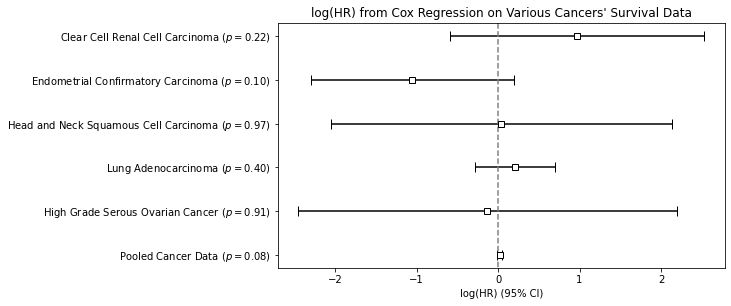

In [72]:
#Plot total Cox

cox_data = {
    "Pooled Cancer Data": [0.08, 0.02, 0.05, -0.00],
    "High Grade Serous Ovarian Cancer": [0.91, -0.13, 2.19, -2.45],
    "Lung Adenocarcinoma": [0.40, 0.21, 0.70, -0.28],
    "Head and Neck Squamous Cell Carcinoma": [0.97, 0.04, 2.13, -2.06],
    "Endometrial Confirmatory Carcinoma": [0.10, -1.05, 0.20, -2.29],
    "Clear Cell Renal Cell Carcinoma": [0.22, 0.97, 2.53, -0.58],
}

plt.rcParams['figure.figsize'] = [8, 4.5]

y_val = list(cox_data.keys())
x_val = [i[1] for i in list(cox_data.values())]
x_err = [i[2]-i[1] for i in list(cox_data.values())]

for i in range(len(x_val)):
    plt.errorbar(
        x_val[i], 
        y_val[i]+" ($p={:.2f}$)".format(list(cox_data.values())[i][0]), 
        xerr=x_err[i], color="black",
        capsize=5, marker="s", mec="black", mfc="white",
                )
    
plt.vlines(x=0, color="gray", linestyle="dashed", ymin=-10, ymax=100)

plt.ylim(-0.3, 5.3)

plt.title("log(HR) from Cox Regression on Various Cancers' Survival Data")
plt.xlabel("log(HR) (95% CI)")

plt.gcf().set_size_inches(8, 4.5)
plt.savefig("cox_ph.svg", dpi=500, bbox_inches='tight')
